In [ ]:
!pip install -qq transformers
!pip install sentencepiece

     |████████████████████████████████| 2.8 MB 5.4 MB/s 
     |████████████████████████████████| 895 kB 45.3 MB/s 
     |████████████████████████████████| 3.3 MB 37.7 MB/s 
     |████████████████████████████████| 636 kB 50.9 MB/s 
     |████████████████████████████████| 52 kB 1.4 MB/s 
     |████████████████████████████████| 1.2 MB 5.7 MB/s 


In [ ]:
import transformers
from transformers import XLNetForSequenceClassification, XLNetTokenizer, AdamW, get_linear_schedule_with_warmup
# Try XLNetForSequenceClassification
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
reviews_df = pd.read_csv("reviews_preprocessed.csv")
reviews_df.head()

,content,score,thumbsUpCount,appId,review_len,word_count,polarity
0,user interface horrible way task show difficul...,0,145,com.anydo,242,40,0.031481
1,keep lose event save enter recur event might s...,0,2,com.anydo,128,22,0.000000
2,adhd want try app help remember chore around h...,0,0,com.anydo,139,22,0.500000
3,point pay premium colour tag dont even show ca...,0,3,com.anydo,123,21,0.000000
4,installed look around instal clunky feel intui...,0,1,com.anydo,136,20,0.100000


In [ ]:
reviews_df.shape

(11879, 7)

In [ ]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11879 entries, 0 to 11878
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   content        11879 non-null  object 
 1   score          11879 non-null  int64  
 2   thumbsUpCount  11879 non-null  int64  
 3   appId          11879 non-null  object 
 4   review_len     11879 non-null  int64  
 5   word_count     11879 non-null  int64  
 6   polarity       11879 non-null  float64
dtypes: float64(1), int64(4), object(2)
memory usage: 649.8+ KB


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


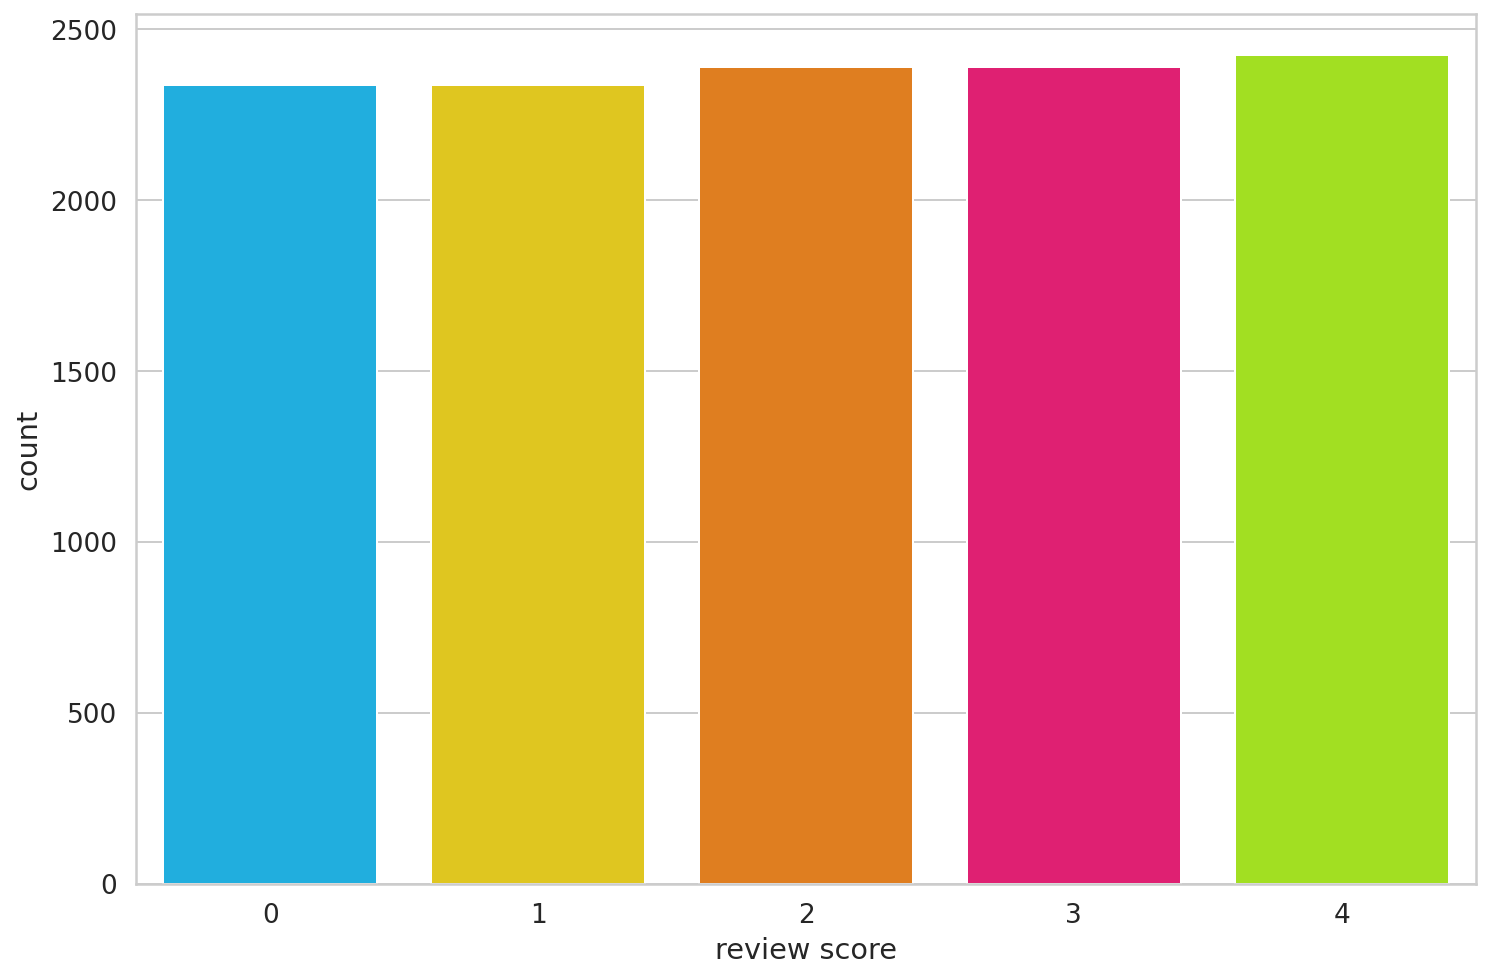

In [ ]:
sns.countplot(reviews_df.score)
plt.xlabel('review score');

In [ ]:
class_names = ['strongly_neg','neg','neutral','pos','strongly_pos']

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


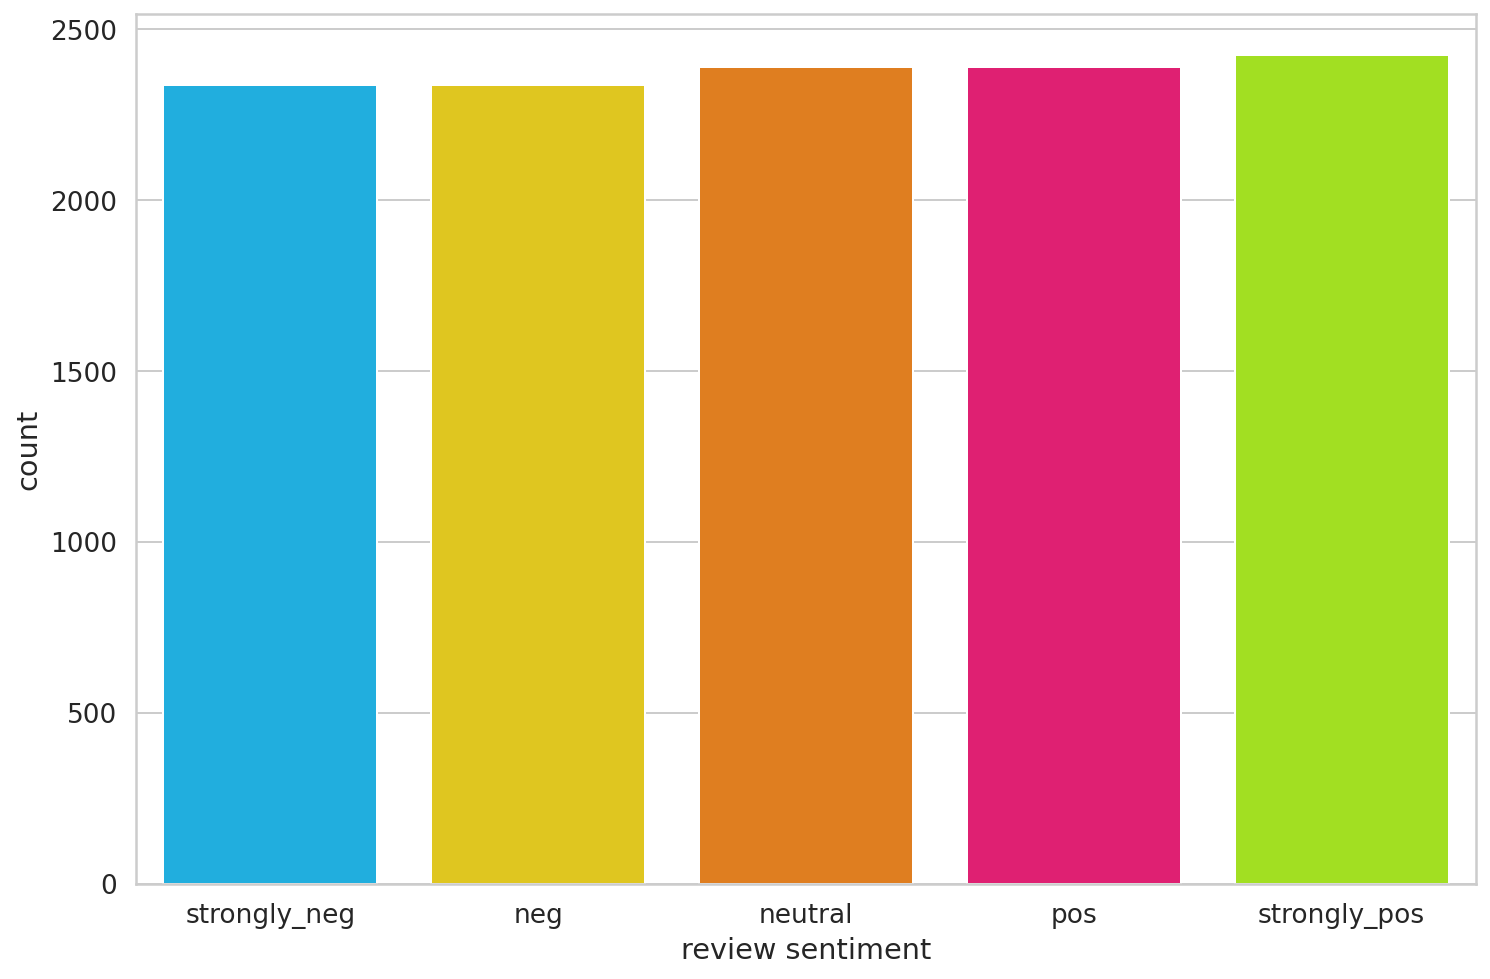

In [ ]:
ax = sns.countplot(reviews_df.score)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names);

In [ ]:
PRE_TRAINED_MODEL_NAME = 'xlnet-base-cased'

In [ ]:
tokenizer = XLNetTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
print(tokenizer)

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/760 [00:00<?, ?B/s]

PreTrainedTokenizer(name_or_path='xlnet-base-cased', vocab_size=32000, model_max_len=1000000000000000019884624838656, is_fast=False, padding_side='left', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '<sep>', 'pad_token': '<pad>', 'cls_token': '<cls>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=True), 'additional_special_tokens': ['<eop>', '<eod>']})


In [ ]:
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'

In [ ]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: When was I last outside? I am stuck at home for 2 weeks.
   Tokens: ['▁When', '▁was', '▁I', '▁last', '▁outside', '?', '▁I', '▁am', '▁stuck', '▁at', '▁home', '▁for', '▁2', '▁weeks', '.']
Token IDs: [311, 30, 35, 129, 684, 82, 35, 569, 5388, 38, 192, 28, 159, 754, 9]


In [ ]:
tokenizer.sep_token, tokenizer.sep_token_id

('<sep>', 4)

In [ ]:
tokenizer.cls_token, tokenizer.cls_token_id

('<cls>', 3)

In [ ]:
tokenizer.pad_token, tokenizer.pad_token_id

('<pad>', 5)

In [ ]:
tokenizer.unk_token, tokenizer.unk_token_id

('<unk>', 0)

In [ ]:
encoding = tokenizer.encode_plus(
  sample_txt,
  truncation=True,
  max_length=32,
  add_special_tokens=True, # Add '<CLS>' and '<SEP>'
  return_token_type_ids=False,
#  pad_to_max_length=True, deprecated
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

In [ ]:
encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [ ]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([   5,    5,    5,    5,    5,    5,    5,    5,    5,    5,    5,    5,
           5,    5,    5,  311,   30,   35,  129,  684,   82,   35,  569, 5388,
          38,  192,   28,  159,  754,    9,    4,    3])

In [ ]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1]])

In [ ]:
print(tokenizer.convert_ids_to_tokens(encoding['input_ids'][0]))

['<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '▁When', '▁was', '▁I', '▁last', '▁outside', '?', '▁I', '▁am', '▁stuck', '▁at', '▁home', '▁for', '▁2', '▁weeks', '.', '<sep>', '<cls>']


In [ ]:
token_lens = []
for txt in reviews_df.content:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


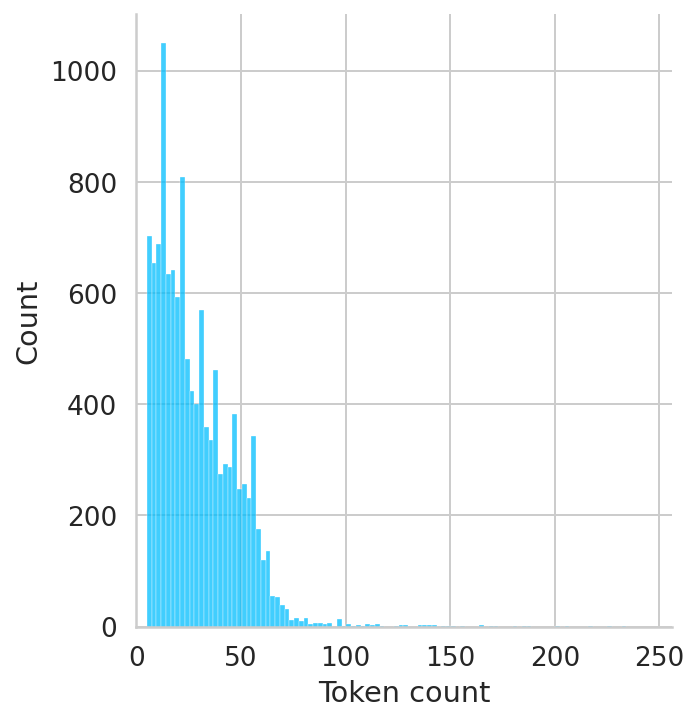

In [ ]:
sns.displot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [ ]:
MAX_LEN = 100

In [ ]:
class GPReviewDataset(Dataset):
  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  def __len__(self):
    return len(self.reviews)
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]
    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      truncation=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
    )
    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
# Split into training and testing data
x = reviews_df['content']
y = reviews_df['score']
x, x_test, y, y_test = train_test_split(x,y, stratify=y, test_size=0.16, random_state=42)

In [ ]:
train_dataset = pd.DataFrame({"content": x, "score":y})

In [ ]:
train_dataset.head()

,content,score
9129,move slow small see,1
3459,app awesome encouraging habit since satisfy pr...,4
2573,ok change 4 5 star new design app pa update ap...,4
166,basic feature like recur task behind pay wall ...,0
675,great app need voiceover would bravo,3


In [ ]:
train_dataset, val_dataset = train_test_split(
  train_dataset,
  test_size=0.15,
  random_state=RANDOM_SEED
)

In [ ]:
test_dataset = pd.DataFrame({"content": x_test, "score":y_test})
test_dataset.head()

,content,score
2561,one best list apps ive use ive used lot best t...,4
5728,pretty decent ignores default repeat value hon...,3
1440,im look schedule call type call click call but...,2
9469,find app really hard use log every 2 sec use,0
4215,app awesome help focus even well improve great...,3


In [ ]:
train_dataset.shape, val_dataset.shape, test_dataset.shape

((8481, 2), (1497, 2), (1901, 2))

In [ ]:
train_dataset = train_dataset.sample(frac=1).reset_index(drop=True)

In [ ]:
test_dataset = test_dataset.sample(frac=1).reset_index(drop=True)

In [ ]:
val_dataset = val_dataset.sample(frac=1).reset_index(drop=True)

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.content.to_numpy(),
    targets=df.score.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )
  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=2
  )

In [ ]:
BATCH_SIZE = 16
train_data_loader = create_data_loader(train_dataset, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(val_dataset, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(test_dataset, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 100])
torch.Size([16, 100])
torch.Size([16])


In [ ]:
xlnet_model = XLNetForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False,num_labels = 5)
xlnet_model

Downloading:   0%|          | 0.00/467M [00:00<?, ?B/s]

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.bias', 'logits_proj.weight', 'sequence_summary.summary.weight', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

XLNetForSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e

In [ ]:
xlnet_model.config.return_dict

False

In [ ]:
xlnet_model.config.num_labels

5

In [ ]:
output, _ = xlnet_model(
  input_ids=encoding['input_ids'],
  attention_mask=encoding['attention_mask']
)

print(output)
print(xlnet_model(
  input_ids=encoding['input_ids'],
  attention_mask=encoding['attention_mask']
))

tensor([[ 0.1571, -0.5036,  0.0664, -0.0773, -0.4435]],
       grad_fn=<AddmmBackward>)
(tensor([[ 0.1571, -0.5036,  0.0664, -0.0773, -0.4435]],
       grad_fn=<AddmmBackward>), (tensor([[[ 0.0344,  0.0202,  0.0261,  ..., -0.0175, -0.0343,  0.0252]],

        [[ 0.0344,  0.0202,  0.0261,  ..., -0.0175, -0.0343,  0.0252]],

        [[ 0.0344,  0.0202,  0.0261,  ..., -0.0175, -0.0343,  0.0252]],

        ...,

        [[-0.0238, -0.0061, -0.0163,  ..., -0.0160,  0.0431, -0.0309]],

        [[ 0.0788, -0.0583, -0.0905,  ...,  0.0493,  0.0634, -0.0520]],

        [[ 0.0181, -0.0015, -0.1494,  ...,  0.0012, -0.0009,  0.0188]]]), tensor([[[ 0.5057,  1.0317, -0.4473,  ..., -0.2606, -0.0783,  0.1577]],

        [[ 0.4932,  0.9692, -0.4842,  ..., -0.3431, -0.0299,  0.2046]],

        [[ 0.4995,  0.8911, -0.5017,  ..., -0.3838,  0.0159,  0.2258]],

        ...,

        [[ 0.2099,  0.7524, -0.3885,  ..., -0.5994, -0.0865, -0.3104]],

        [[ 1.7141, -0.2767, -2.0536,  ...,  0.4893,  0.5218,  

In [ ]:
xlnet_model.config.hidden_size

768

In [ ]:
output

tensor([[ 0.1571, -0.5036,  0.0664, -0.0773, -0.4435]],
       grad_fn=<AddmmBackward>)

In [ ]:
nn.functional.softmax(output, dim=1)

tensor([[0.2653, 0.1370, 0.2423, 0.2099, 0.1455]], grad_fn=<SoftmaxBackward>)

In [ ]:
class SentimentClassifier(nn.Module):
# def __init__(self, n_classes):
  def __init__(self):
    super(SentimentClassifier, self).__init__()
    self.xlnet = XLNetForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False, num_labels= 5)
#   self.drop = nn.Dropout(p=0.3)
#   self.out = nn.Linear(self.xlnet.config.hidden_size, n_classes)
  def forward(self, input_ids, attention_mask):
    
    output = self.xlnet(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
#    print(output[0])
#   output = self.drop(pooled_output)
#   return self.out(output)
    return output[0]

In [ ]:
model = SentimentClassifier()
model = model.to(device)

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.bias', 'logits_proj.weight', 'sequence_summary.summary.weight', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 100])
torch.Size([16, 100])


In [ ]:
nn.functional.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.1102, 0.3357, 0.2391, 0.1480, 0.1670],
        [0.0837, 0.3444, 0.2481, 0.1985, 0.1253],
        [0.2219, 0.2888, 0.1726, 0.1474, 0.1693],
        [0.1604, 0.3543, 0.1714, 0.1553, 0.1586],
        [0.0741, 0.3668, 0.1901, 0.2297, 0.1393],
        [0.0637, 0.2929, 0.2160, 0.2562, 0.1711],
        [0.0590, 0.3730, 0.2751, 0.1647, 0.1281],
        [0.0728, 0.2830, 0.2625, 0.2386, 0.1431],
        [0.0945, 0.2730, 0.1576, 0.3675, 0.1074],
        [0.0712, 0.3393, 0.2361, 0.1536, 0.1998],
        [0.1102, 0.3302, 0.1889, 0.2310, 0.1397],
        [0.1038, 0.2783, 0.2043, 0.2742, 0.1393],
        [0.1004, 0.2764, 0.2851, 0.2158, 0.1223],
        [0.1206, 0.2733, 0.2098, 0.2970, 0.0993],
        [0.1030, 0.3751, 0.2434, 0.1902, 0.0884],
        [0.1204, 0.3406, 0.2264, 0.1653, 0.1472]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)

In [ ]:
EPOCHS = 10
optimizer = AdamW(model.parameters(), lr=7e-6, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()
  losses = []
  correct_predictions = 0
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 30)
  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(train_dataset)
  )
  print(f'Train loss {train_loss} accuracy {train_acc}')
  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(val_dataset)
  )
  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  PATH = 'train_valid-epoch{}.pth'.format(epoch)
  if(epoch == 2 or epoch == 6 or epoch == 8):
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'train_accuracy':train_acc,
            'val_loss': val_loss,
            'val_accuracy': val_acc
            }, PATH)

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  if val_acc > best_accuracy:
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'train_accuracy':train_acc,
            'val_loss': val_loss,
            'val_accuracy': val_acc
            }, 'best_model_state.pth')
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/10
------------------------------
Train loss 1.396335315457396 accuracy 0.3586841174389812
Val   loss 1.2752787483499406 accuracy 0.4195056780227121

Epoch 2/10
------------------------------
Train loss 1.1699885747302499 accuracy 0.4939276028770192
Val   loss 1.1918640517173928 accuracy 0.4903139612558451

Epoch 3/10
------------------------------
Train loss 1.0774806213693207 accuracy 0.538144086782219
Val   loss 1.2143198568770226 accuracy 0.4936539746158985

Epoch 4/10
------------------------------
Train loss 1.013620934580679 accuracy 0.5726918995401485
Val   loss 1.253836191080986 accuracy 0.49632598530394123

Epoch 5/10
------------------------------
Train loss 0.9518931647815273 accuracy 0.5999292536257517
Val   loss 1.300357073545456 accuracy 0.4949899799599199

Epoch 6/10
------------------------------
Train loss 0.910155714680695 accuracy 0.6259875014738827
Val   loss 1.3299187872004001 accuracy 0.488309953239813

Epoch 7/10
------------------------------
Train loss

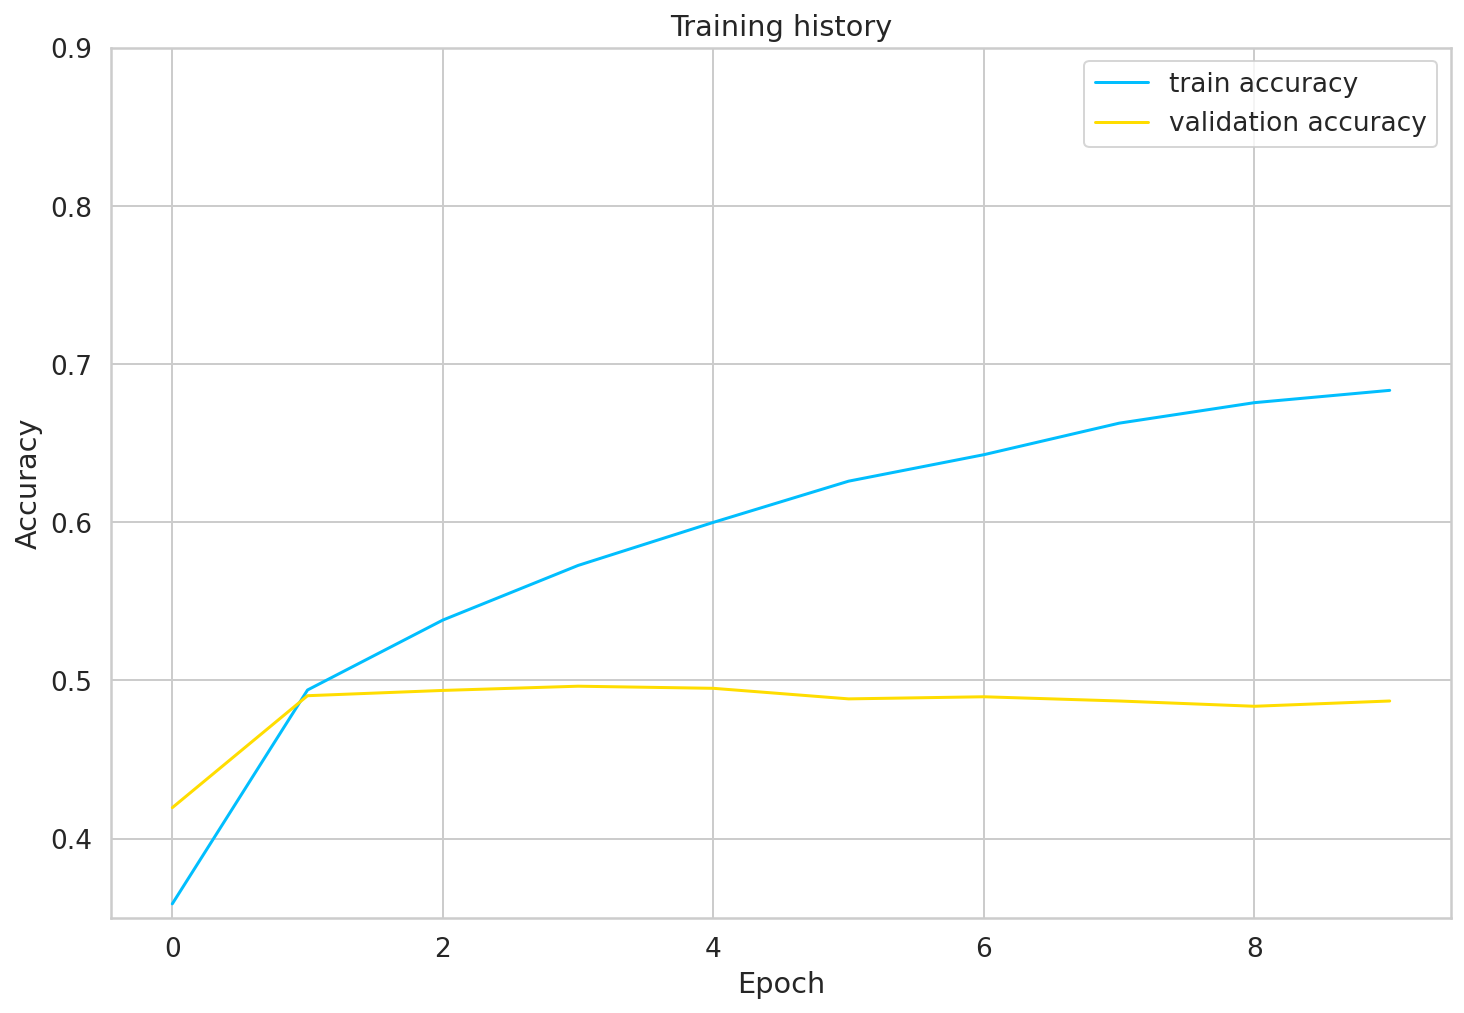

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.35, 0.9]);
# Explain why you run only 7 epochs and stop the running

In [ ]:
model = SentimentClassifier()
model.load_state_dict(torch.load('best_model_state.bin'))
model = model.to(device)

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.bias', 'logits_proj.weight', 'sequence_summary.summary.weight', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

In [ ]:
test_acc, test_loss = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(test_dataset)
)

In [ ]:
test_acc.item()

0.49132035770647026

In [ ]:
test_loss

1.251769041814724

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()

  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  enter = True
  with torch.no_grad():
    for d in data_loader:
      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      if(enter):
        print(outputs)
        enter = False


      _, preds = torch.max(outputs, dim=1)
      review_texts.extend(texts)
      predictions.extend(preds)
      softmax_outputs = nn.functional.softmax(outputs, dim=1)
      prediction_probs.extend(softmax_outputs)
      real_values.extend(targets)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_test_old = y_test

In [ ]:
y_review_texts, y_pred, y_pred_proba, y_test = get_predictions(
  model,
  test_data_loader
)

tensor([[-2.2366, -2.4581, -1.1522,  1.5167,  3.8462],
        [-1.2816, -1.8844, -1.2944, -0.0983,  3.4432],
        [-1.1398,  0.9161,  2.1283,  1.0816, -1.8221],
        [ 4.0564,  1.1690,  0.0869, -1.9595, -2.4207],
        [-1.8620, -2.4825, -1.5899,  0.6014,  4.2979],
        [-2.3574, -2.5715, -1.4673,  1.3184,  4.1729],
        [-2.8324, -2.1842, -0.4780,  2.4575,  2.4991],
        [ 3.8905,  1.5252,  0.2322, -1.8675, -2.5910],
        [-0.9934,  0.5085,  2.5685,  0.9006, -2.0769],
        [ 1.9107,  2.2560,  1.0889, -1.0510, -2.6624],
        [-2.5005, -1.2612,  0.1098,  1.7862,  1.5713],
        [-1.8541, -2.7530, -1.7689,  0.4981,  4.5966],
        [-1.5081, -2.6456, -1.6368,  0.4185,  4.4330],
        [-1.4279, -1.8064, -1.3564,  0.1788,  3.2416],
        [-1.7286,  0.2805,  2.3555,  1.3134, -1.4588],
        [-1.5348,  0.3209,  1.9564,  1.2832, -0.9628]], device='cuda:0')


In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

strongly_neg       0.56      0.60      0.58       374
         neg       0.40      0.30      0.34       374
     neutral       0.36      0.42      0.39       383
         pos       0.46      0.47      0.46       382
strongly_pos       0.69      0.66      0.67       388

    accuracy                           0.49      1901
   macro avg       0.49      0.49      0.49      1901
weighted avg       0.49      0.49      0.49      1901



In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="f", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');


In [ ]:
conf_mx = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(conf_mx, index=class_names, columns=class_names)
print(conf_mx)

[[224  83  52   8   7]
 [113 113 115  26   7]
 [ 44  72 161  87  19]
 [  8  13  97 180  84]
 [  8   3  27  94 256]]


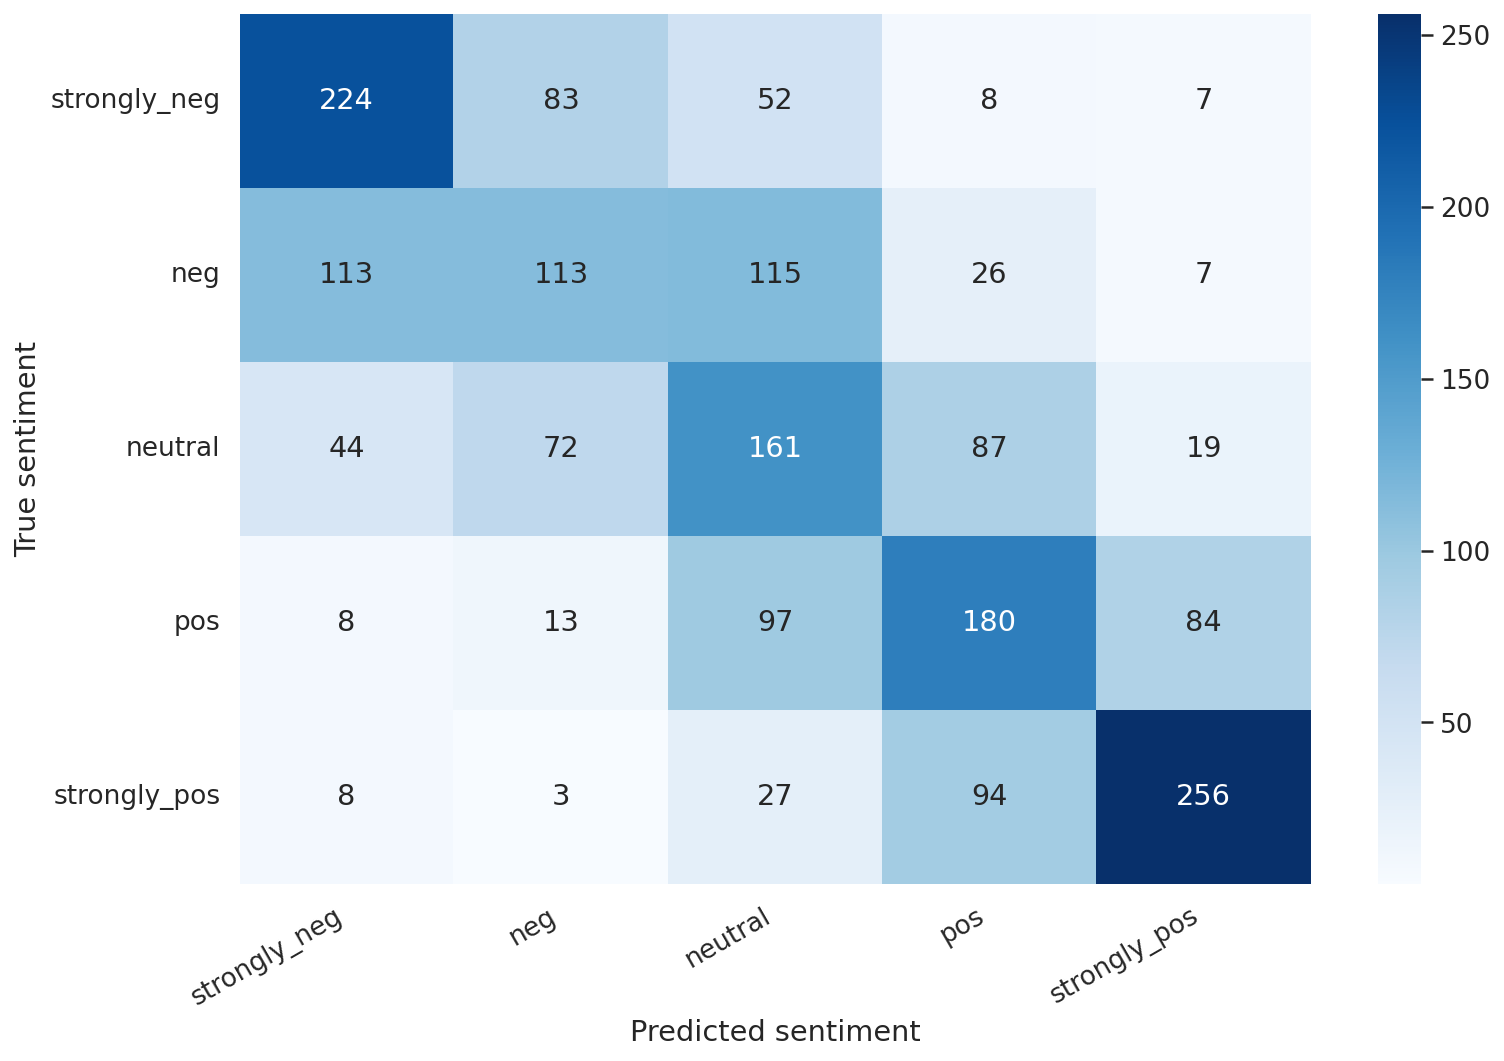

In [ ]:
show_confusion_matrix(df_cm)

In [ ]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
print(row_sums)
norm_conf_mx = conf_mx / row_sums

[[374]
 [374]
 [383]
 [382]
 [388]]


In [ ]:
print(norm_conf_mx)

[[0.59893048 0.22192513 0.13903743 0.02139037 0.01871658]
 [0.30213904 0.30213904 0.30748663 0.06951872 0.01871658]
 [0.11488251 0.18798956 0.42036554 0.22715405 0.04960836]
 [0.02094241 0.03403141 0.2539267  0.47120419 0.21989529]
 [0.02061856 0.00773196 0.06958763 0.24226804 0.65979381]]


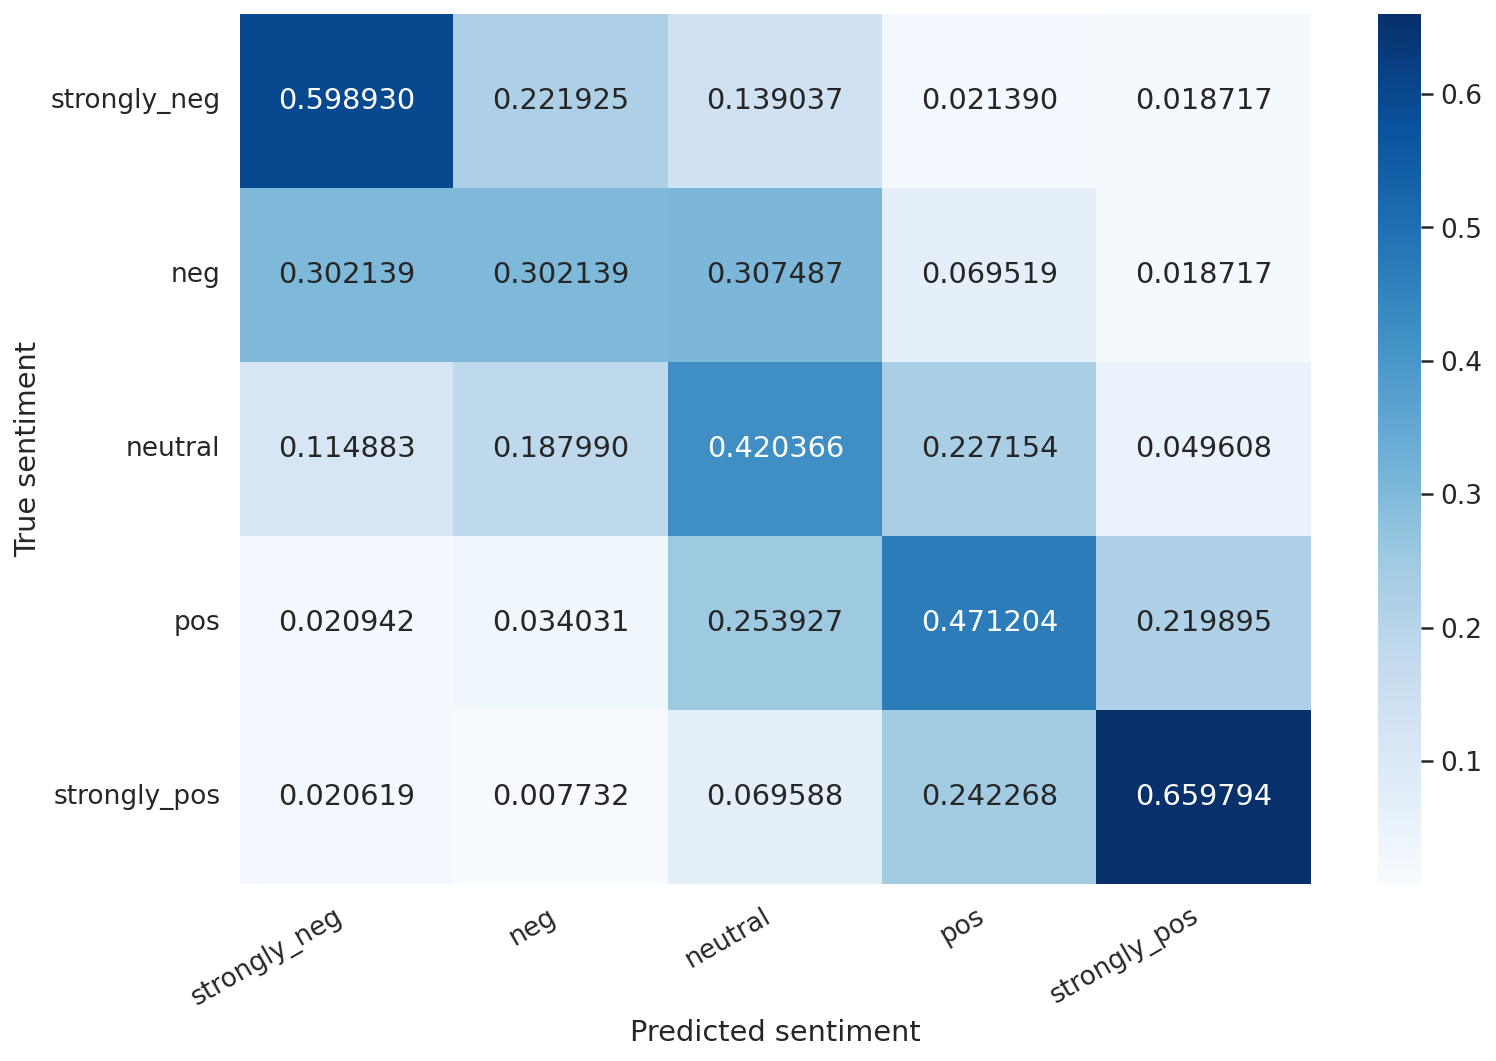

In [ ]:
df_norm_cm = pd.DataFrame(norm_conf_mx, index=class_names, columns=class_names)
show_confusion_matrix(df_norm_cm)

In [ ]:
np.fill_diagonal(norm_conf_mx, 0)

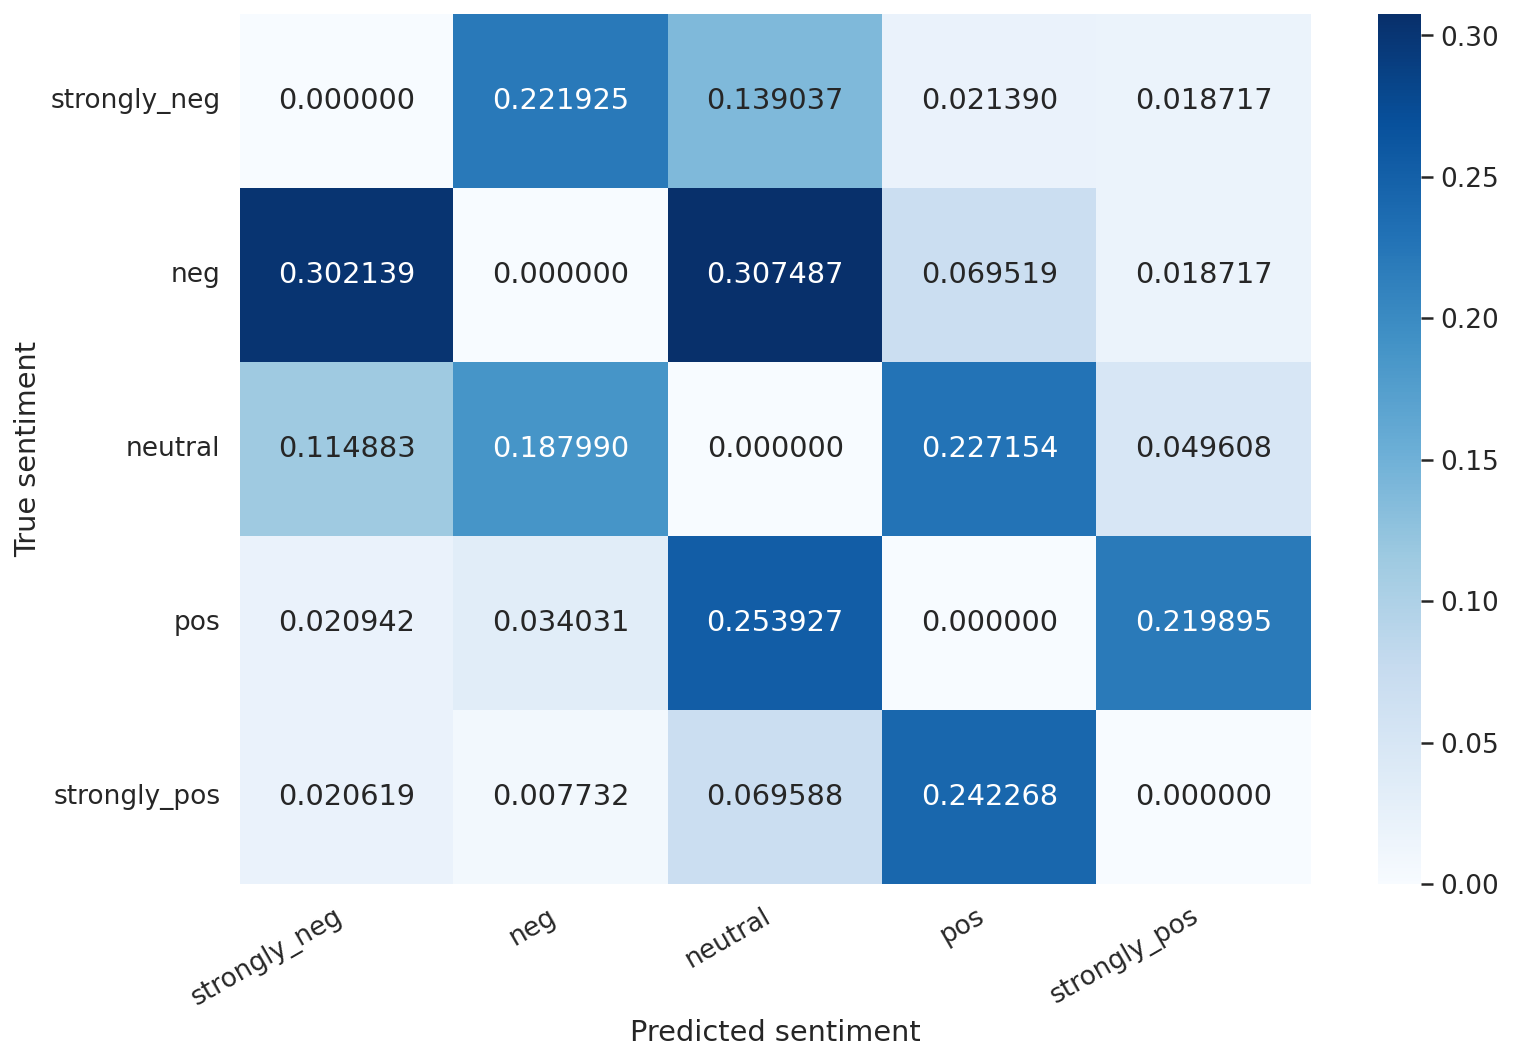

In [ ]:
df_norm_cm = pd.DataFrame(norm_conf_mx, index=class_names, columns=class_names)
show_confusion_matrix(df_norm_cm)

In [ ]:
print(norm_conf_mx)

[[0.         0.22192513 0.13903743 0.02139037 0.01871658]
 [0.30213904 0.         0.30748663 0.06951872 0.01871658]
 [0.11488251 0.18798956 0.         0.22715405 0.04960836]
 [0.02094241 0.03403141 0.2539267  0.         0.21989529]
 [0.02061856 0.00773196 0.06958763 0.24226804 0.        ]]


Precison / Recall

In [ ]:
from sklearn.preprocessing import label_binarize

In [ ]:
# Use label_binarize to be multi-label like settings
y_test_mult = label_binarize(y_test, classes=[0, 1, 2, 3, 4])
print(y_test_mult)
print(y_pred_proba)

n_classes = y_test_mult.shape[1]
n_classes

[[0 0 0 1 0]
 [0 0 0 0 1]
 [0 0 1 0 0]
 ...
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 0 1 0 0]]
tensor([[0.0021, 0.0016, 0.0061, 0.0878, 0.9024],
        [0.0084, 0.0046, 0.0083, 0.0276, 0.9511],
        [0.0223, 0.1744, 0.5862, 0.2058, 0.0113],
        ...,
        [0.0364, 0.1990, 0.6145, 0.1276, 0.0226],
        [0.0144, 0.0772, 0.7545, 0.1457, 0.0082],
        [0.0420, 0.2823, 0.5746, 0.0925, 0.0087]])


5

In [ ]:
print(len(y_test_mult))
print(len(y_pred_proba))

1901
1901


In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

In [ ]:
# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_mult[:, i],
                                                        y_pred_proba[:, i])
    
    curr_precision = precision[i]
    curr_recall = recall[i]

    precision[i] = precision[i][curr_precision+curr_recall > 0.0]
    recall[i] = recall[i][curr_precision+curr_recall > 0.0]

    average_precision[i] = average_precision_score(y_test_mult[:, i], y_pred_proba[:, i])

In [ ]:
# A "macro-average": Averaging over classes
# ====> Cannot do macro-average by the below approach because:
# len(precision[i]) depend on i (the unique probas in column i)
# the thresholds that based on it the precision & recall are calculated is not the same at the corresponding indices
#precision_sum = precision[0] + precision[1] + precision[2] + precision[3] + precision[4]
#precision["macro"] = precision_sum / 5
#recall_sum = recall[0] + recall[1] + recall[2] + recall[3] + recall[4]
#recall["macro"] = recall_sum / 5

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test_mult.ravel(),
    y_pred_proba.ravel())


# compute F1 score
f1_score = dict()
# for each class
for i in range(n_classes):
  f1_score[i] = 2*((precision[i]*recall[i])/(precision[i]+recall[i]))

f1_score["micro"] = 2*((precision["micro"]*recall["micro"])/(precision["micro"]+recall["micro"]))

In [ ]:
average_precision["micro"] = average_precision_score(y_test_mult, y_pred_proba,
                                                     average="micro")
average_precision["macro"] = average_precision_score(y_test_mult, y_pred_proba,
                                                     average="macro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))
print('Average precision score, macro-averaged over all classes: {0:0.2f}'
      .format(average_precision["macro"]))

Average precision score, micro-averaged over all classes: 0.54
Average precision score, macro-averaged over all classes: 0.50


Plot the micro-averaged Precision-Recall curve

Text(0.5, 1.0, 'Average precision score, micro-averaged over all classes: AP=0.54')

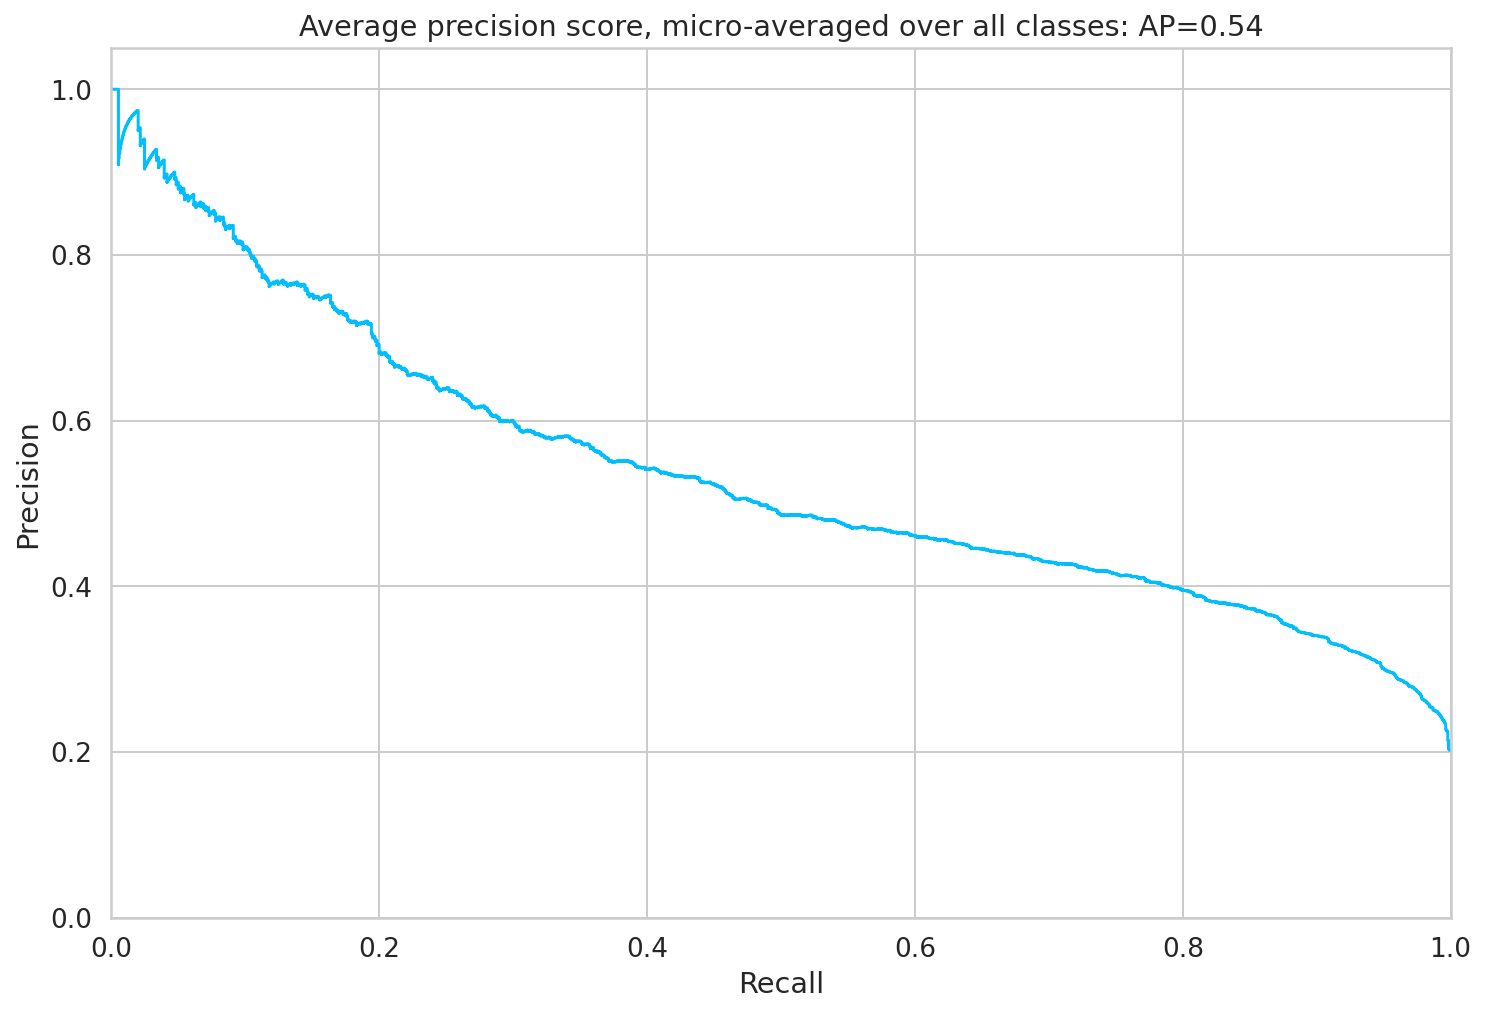

In [ ]:
plt.figure()
plt.step(recall['micro'], precision['micro'], where='post')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]))

Plot Precision-Recall curve for each class and iso-f1 curves

In [ ]:
from itertools import cycle

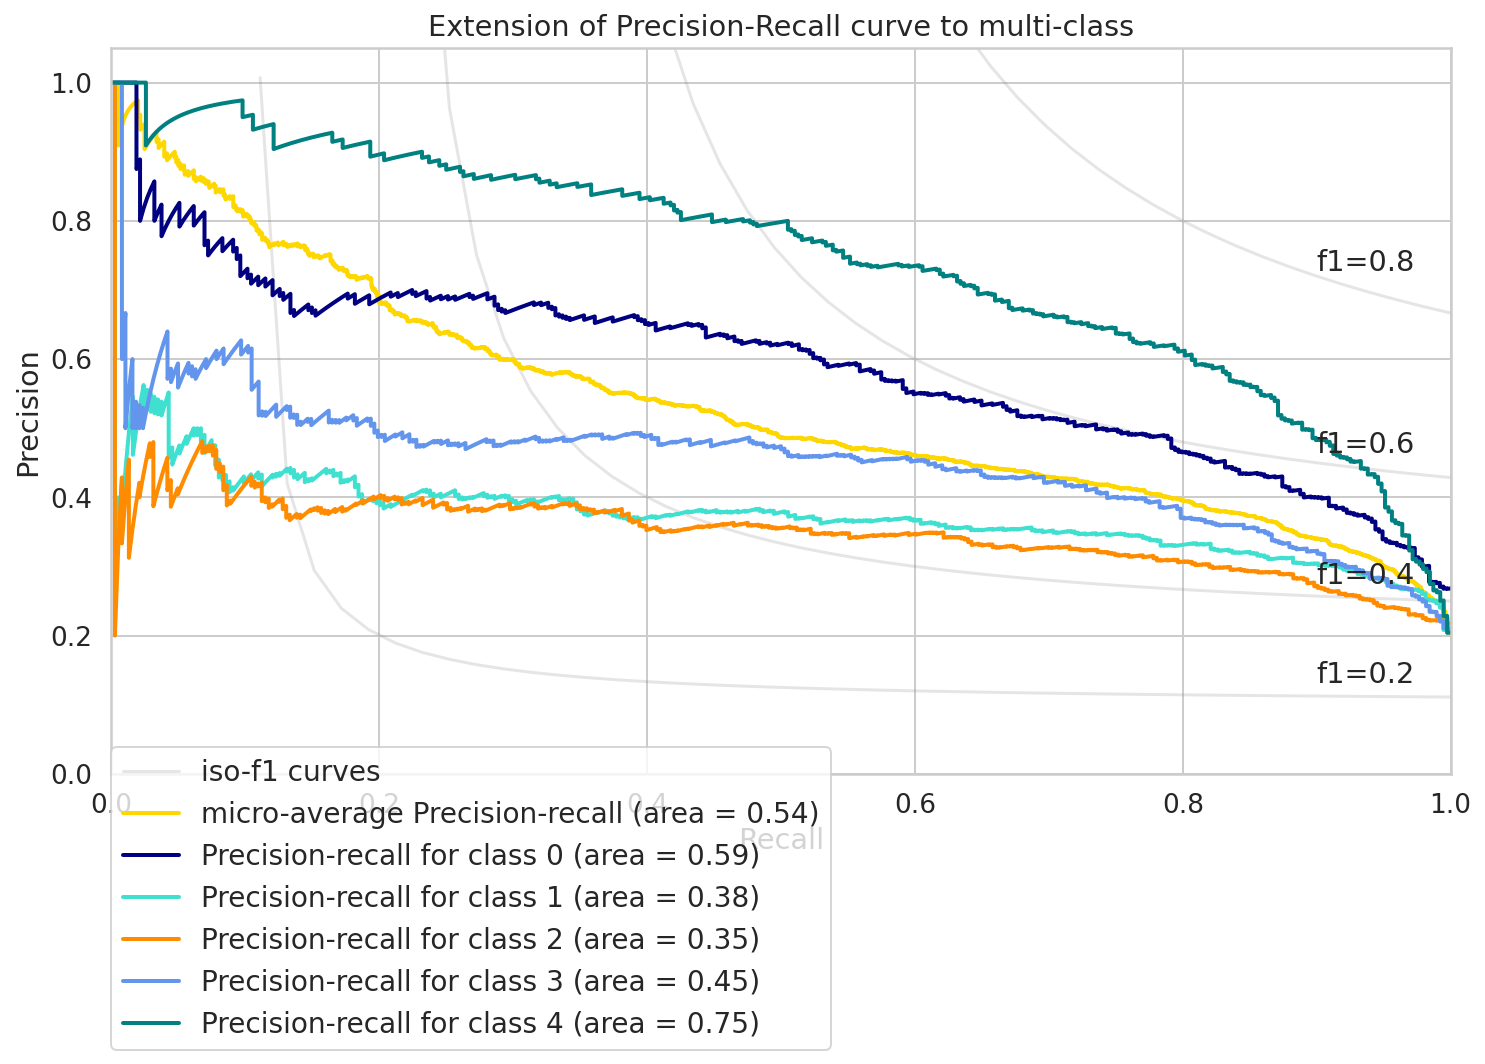

In [ ]:
# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

plt.figure(figsize=(12, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

for i, color in zip(range(n_classes), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                  ''.format(i, average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Extension of Precision-Recall curve to multi-class')
plt.legend(lines, labels, loc=(0, -.38), prop=dict(size=14))


plt.show()


In [ ]:
idx = 2

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_proba[idx]
})

print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

fun cool would 5 star know habitica die quickly litterally log
partyconfusion dead someone didnt log day also bos deal damage deal
damage deal healer heal 6 health 50 use 25 mana point teammate use
mana try keep alive check daily yesterday die dealt 11 bos deal 14
plus fix team agree fix

True sentiment: neutral


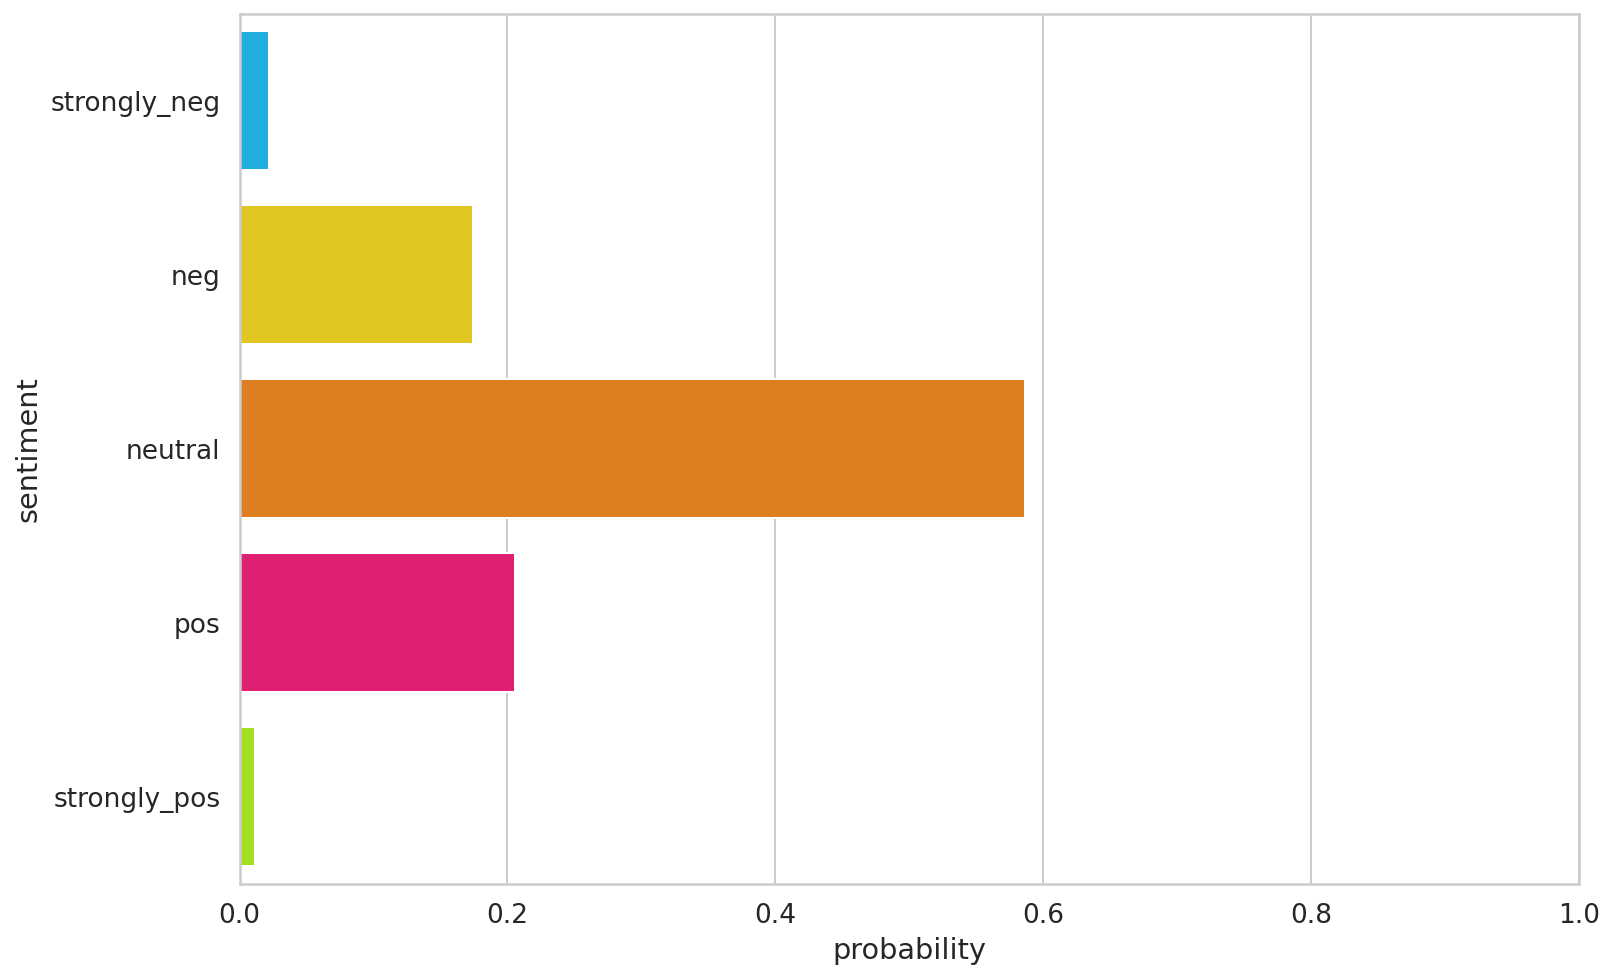

In [ ]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

In [ ]:
review_text = "I love completing my todos! Best app ever!!!"

In [ ]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2204: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')


Review text: I love completing my todos! Best app ever!!!
Sentiment  : strongly_pos
